In [5]:
import numpy as np
import flow
import os
import matplotlib.pyplot as plt
from munkres import Munkres
from scipy.cluster import hierarchy
import seaborn as sns
# import tensortools as tt
import random
import pandas as pd
from copy import deepcopy
from cascade import tca
from cascade import paths
from cascade import utils

In [8]:
mice = ['OA27', 'OA26']
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
words=['supply', 'supply']
group_by='high_dprime_learning'
nan_thresh=None
verbose=False
rank_num=10

In [14]:

"""
Plot reconstruction error as variance explained across all whole groupday
TCA decomposition ensemble.

Parameters:
-----------
mouse : str; mouse name
trace_type : str; dff, zscore, deconvolved
method : str; TCA fit method from tensortools

Returns:
--------
Saves figures to .../analysis folder  .../qc
"""

pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}
group_pars = {'group_by': group_by}

# if cells were removed with too many nan trials
if nan_thresh:
    nt_tag = '_nantrial' + str(nan_thresh)
    nt_save_tag = ' nantrial ' + str(nan_thresh)
else:
    nt_tag = ''
    nt_save_tag = ''

# save dir
group_word = paths.groupmouse_word({'mice': mice})
mouse = 'Group-' + group_word
save_dir = paths.tca_plots(
    mouse, 'group', pars=pars, word=words[0], group_pars=group_pars)
save_dir = os.path.join(save_dir, 'qc' + nt_save_tag)
if not os.path.isdir(save_dir): os.mkdir(save_dir)
var_path = os.path.join(
    save_dir, str(mouse) + '_hierarchical_clustering_n' + str(len(mice)) + '.pdf')

# create figure and axes
# buffer = 5
# right_pad = 5
# fig = plt.figure(figsize=(10, 8))
# gs = GridSpec(
#     100, 100, figure=fig, left=0.05, right=.95, top=.95, bottom=0.05)
# ax = fig.add_subplot(gs[10:90-buffer, :90-right_pad])
# cmap = sns.color_palette('hls', len(mice))

conds_by_day = []
oris_by_day = []
trialerr_by_day = []
# neuron_ids_by_day = []
# neuron_clusters_by_day = []
# factors_by_day = []
day_list = []
df_list_tempo = []
df_list_tuning = []
df_list_conds = []
df_list_error = []
df_list_index = []
for mnum, mouse in enumerate(mice):
    # load dir
    load_dir = paths.tca_path(
        mouse, 'group', pars=pars, word=words[mnum], group_pars=group_pars)
    tensor_path = os.path.join(
        load_dir, str(mouse) + '_' + str(group_by) + nt_tag
        + '_group_decomp_' + str(trace_type) + '.npy')
    ids_path = os.path.join(
        load_dir, str(mouse) + '_' + str(group_by) + nt_tag
        + '_group_ids_' + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(
        load_dir, str(mouse) + '_' + str(group_by) + nt_tag
        + '_group_tensor_' + str(trace_type) + '.npy')
    meta_path = os.path.join(
        load_dir, str(mouse) + '_' + str(group_by) + nt_tag
        + '_df_group_meta.pkl')

    # load your data
    ensemble = np.load(tensor_path, allow_pickle=True)
    ensemble = ensemble.item()
    meta = pd.read_pickle(meta_path)
    meta = utils.update_naive_cs(meta)
    ids = np.load(ids_path)
    orientation = meta['orientation']
    condition = meta['condition']
    trialerror = meta['trialerror']
    hunger = deepcopy(meta['hunger'])
    speed = meta['speed']
    dates = meta.reset_index()['date']
    learning_state = meta['learning_state']

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]

    # ------------- GET TUNING

    trial_weights = sort_ensemble.results[rank_num][0].factors[2][:, :]
    tuning_weights = np.zeros((3, rank_num))
    oris_to_check = [0, 135, 270]
    for c, ori in enumerate(oris_to_check):
        tuning_weights[c, :] = np.nanmean(
            trial_weights[orientation == ori, :], axis=0)
    # normalize using summed mean response to all three
    tuning_total = np.nansum(tuning_weights, axis=0)
    for c in range(len(oris_to_check)):
        tuning_weights[c, :] = np.divide(tuning_weights[c, :], tuning_total)
    # dict for creating dataframe
    tuning_data = {}
    for c, errset in enumerate(oris_to_check):
        tuning_data['t' + str(errset)] = tuning_weights[c, :]

    # ------------- GET Condition TUNING

    trial_weights = sort_ensemble.results[rank_num][0].factors[2][:, :]
    conds_to_check = ['plus', 'minus', 'neutral']
    conds_weights = np.zeros((len(conds_to_check), rank_num))
    for c, conds in enumerate(conds_to_check):
        conds_weights[c, :] = np.nanmean(
            trial_weights[condition == conds, :], axis=0)
    # normalize using summed mean response to all three
    conds_total = np.nansum(conds_weights, axis=0)
    for c in range(len(conds_to_check)):
        conds_weights[c, :] = np.divide(conds_weights[c, :], conds_total)
    # dict for creating dataframe
    conds_data = {}
    for c, errset in enumerate(conds_to_check):
        conds_data[errset] = conds_weights[c, :]

    # ------------- GET Trialerror TUNING

    trial_weights = sort_ensemble.results[rank_num][0].factors[2][:, :]
    err_to_check = [[0], [1], [2, 4], [3, 5]]  # hit, miss, CR, FA
    err_val = ['hit', 'miss', 'correct_reject', 'false_alarm']
    error_weights = np.zeros((len(err_to_check), rank_num))
    for c, errset in enumerate(err_to_check):
        error_weights[c, :] = np.nanmean(
            trial_weights[trialerror.isin(errset), :], axis=0)
    # normalize using summed mean response to all three
    error_total = np.nansum(error_weights, axis=0)
    for c in range(len(err_to_check)):
        error_weights[c, :] = np.divide(error_weights[c, :], error_total)
    # dict for creataing dataframe
    error_data = {}
    for c, errset in enumerate(err_val):
        error_data[errset] = error_weights[c, :]

    # ------------ CREATE PANDAS DF

    index = pd.MultiIndex.from_arrays([
        [mouse] * rank_num,
#         [day1.date] * rank_num,
        range(1, rank_num+1)
        ],
        names=['mouse', 'component'])
    tempo_df = pd.DataFrame(sort_ensemble.results[rank_num][0].factors[1][:, :].T, index=index)
    tuning_df = pd.DataFrame(tuning_data, index=index)
    conds_df = pd.DataFrame(conds_data, index=index)
    error_df = pd.DataFrame(error_data, index=index)
    df_list_tempo.append(tempo_df)
    df_list_tuning.append(tuning_df)
    df_list_conds.append(conds_df)
    df_list_error.append(error_df)
    df_list_index.append(pd.DataFrame(index=index))

#     factors_by_day.append(sort_ensemble.results[rank_num][0])
    conds_by_day.append(condition)
    oris_by_day.append(orientation)
    trialerr_by_day.append(trialerror)

# concatenate all runs together in final dataframe
all_tempo_df = pd.concat(df_list_tempo, axis=0)
all_tuning_df = pd.concat(df_list_tuning, axis=0)
all_conds_df = pd.concat(df_list_conds, axis=0)
all_error_df = pd.concat(df_list_error, axis=0)
all_index_df = pd.concat(df_list_index, axis=0)


Mice hashed: greatest
Updated naive cs-ori pairings to match learning.
270 plus
135 minus
0 neutral
Updated naive cs-ori pairings to match learning.
270 plus
135 minus
0 neutral


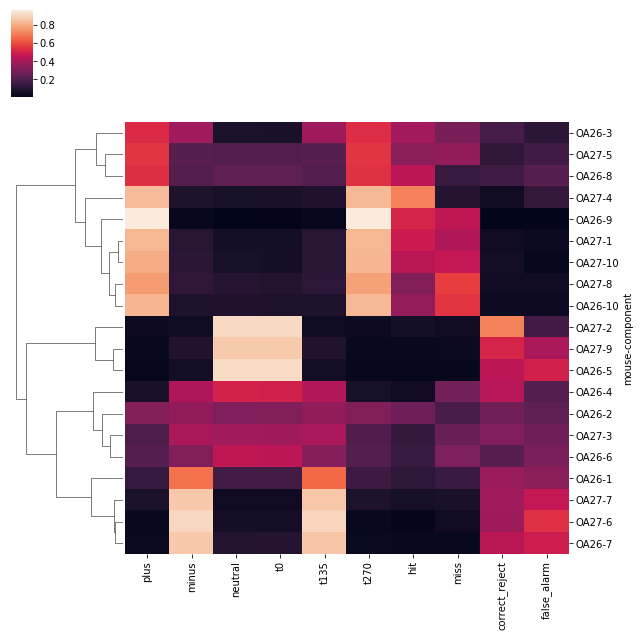

In [28]:
g = sns.clustermap(sdf, col_cluster=False, ) #  method='ward',) #row_colors=colors_shape)

In [22]:
sdf = pd.concat([all_conds_df, all_tuning_df, all_error_df], axis=1)

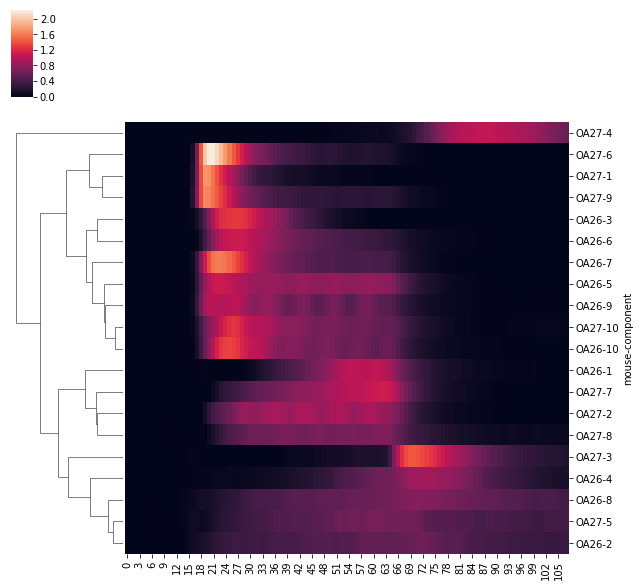

In [29]:
g = sns.clustermap(all_tempo_df, col_cluster=False, )